#Risk assessment

This notebook presents an exploration of different ways to assess the risk of recidivism based on a risk score.

Copyright 2015 Allen Downey

MIT License: http://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import thinkbayes2
import thinkplot

import matplotlib.pyplot as plt

import statsmodels.formula.api as smf

%matplotlib inline

Read the data:

In [2]:
df = pd.read_excel('helmus10yrfixed.xlsx')
df['recid'] = df['10-yr recidivate']
df.head()

,score,10-yr recidivate,recid
0,-2,0,0
1,-2,0,0
2,-1,0,0
3,-1,0,0
4,-1,0,0


The last row of the table is the total, so we have to drop it.

In [3]:
df.tail()

,score,10-yr recidivate,recid
699,10,1,1
700,10,1,1
701,10,1,1
702,11,0,0
703,NaN,204,204


Done.

In [4]:
df = df.dropna()
df.tail()

,score,10-yr recidivate,recid
698,10,1,1
699,10,1,1
700,10,1,1
701,10,1,1
702,11,0,0


###Logistic regression

Start with a logistic regression.

In [5]:
formula = 'recid ~ score'
model = smf.logit(formula, data=df)
results = model.fit(disp=False)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  recid   No. Observations:                  703
Model:                          Logit   Df Residuals:                      701
Method:                           MLE   Df Model:                            1
Date:                Fri, 13 Nov 2015   Pseudo R-squ.:                 0.03919
Time:                        09:56:23   Log-Likelihood:                -406.84
converged:                       True   LL-Null:                       -423.43
                                        LLR p-value:                 8.371e-09
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.8129      0.194     -9.335      0.000        -2.194    -1.432
score          0.2048      0.037      5.534      0.000         0.132     0.277
==============================================================================
"""

We can use the model to predict probabilities for each score:

In [6]:
scores = range(-3, 13)
scores

[-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [7]:
def make_predictions(results, scores):
    columns = ['score']
    new = pd.DataFrame(scores, columns=columns)
    return results.predict(new)

ps = make_predictions(results, scores)
for score, p in zip(scores, ps):
    print(score, p)

-3 0.0811230553353
-2 0.0977539746983
-1 0.117358915927
0 0.140284367251
1 0.166841660229
2 0.197272884005
3 0.231710970071
4 0.270137790771
5 0.312346491893
6 0.357916109828
7 0.406206803608
8 0.456381885955
9 0.507458085398
10 0.558379071389
11 0.608101233976
12 0.655677299314


And here's what that looks like graphically:

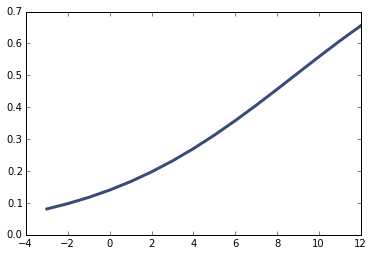

In [8]:
thinkplot.Plot(scores, ps)

Equivalently, we could get the fitted values from the results, which are in the form of log-odds, and convert to probabilities.

In [9]:
odds = np.exp(results.fittedvalues)
ps = odds / (1 + odds)
ps.head()

0    0.097754
1    0.097754
2    0.117359
3    0.117359
4    0.117359
dtype: float64

To show confidence intervals on the estimated probabilities, we could transform the confidence intervals on the estimated parameters, but I prefer to do it by resampling.

Here's a simple version that plots 200 estimated lines to show uncertainty visually.

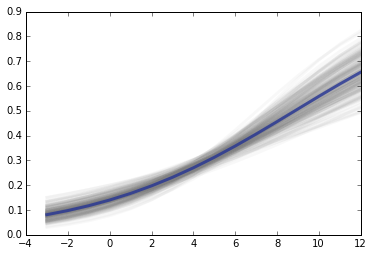

In [10]:
def plot_regression_lines(df, scores):
    columns = ['score']
    new = pd.DataFrame(scores, columns=columns)

    formula = 'recid ~ score'

    for i in range(200):
        sample = df.sample(len(df), replace=True)
        model = smf.logit(formula, data=sample)
        results = model.fit(disp=False)
        ps = results.predict(new)
        thinkplot.Plot(scores, ps, color='gray', alpha=0.05)
        
plot_regression_lines(df, scores)

ps = make_predictions(results, scores)
thinkplot.Plot(scores, ps)

Here's a more complicated version that plots the median of the resampled estimates in each column, and a 95% confidence interval.

/home/downey/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


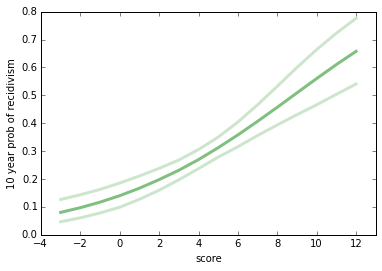

In [11]:
def run_regressions(df, scores, iters=1000, formula='recid ~ score', color='gray'):
    columns = ['score']
    new = pd.DataFrame(scores, columns=columns)
    new['score2'] = new.score**2
    
    array = np.zeros((iters, len(scores)))

    for i in range(iters):
        sample = df.sample(len(df), replace=True)
        model = smf.logit(formula, data=sample)
        results = model.fit(disp=False)
        ps = results.predict(new)
        array[i,] = ps

    array = np.sort(array, axis=0)    
    percents = [2.5, 50, 97.5]
    rows = [thinkbayes2.PercentileRow(array, p) for p in percents]
    return rows
    
def plot_regressions(df, iters=1000, formula='recid ~ score', color='gray'):
    scores = range(-3, 13)
    rows = run_regressions(df, scores, iters, formula, color)
    thinkplot.Plot(scores, rows[0], color=color, alpha=0.2)
    thinkplot.Plot(scores, rows[1], color=color, alpha=0.5)
    thinkplot.Plot(scores, rows[2], color=color, alpha=0.2)
    
plot_regressions(df, iters=1000, color='green')
thinkplot.Config(xlabel='score', ylabel='10 year prob of recidivism', xlim=[-4, 13])

### Bayesian logistic regression

This turns out not to be particularly useful, so feel free to skip it.

An alternative is Bayesian regression.  To demonstrate how it works, I'll use the parameters estimated by logistic regression to compute the likelihood of the data.

In [12]:
slope, inter = (results.params['score'], results.params['Intercept'])
slope, inter

(0.20475163024127738, -1.8129301177982706)

We can use the parameters to compute log-odds, convert to probabilities, then compute the probability of each actual outcome.

In [13]:
log_odds = df.score * slope + inter
odds = np.exp(log_odds)
ps = odds / (1 + odds)
likes = ps * df.recid + (1-ps) * (1-df.recid)
likes.head()

0    0.902246
1    0.902246
2    0.882641
3    0.882641
4    0.882641
dtype: float64

The product of these likelihoods is the likelihood of the data.  The log-likelihood we get is the same as the output of the logistic regression:

In [14]:
np.log(np.prod(likes)), results.llf

(-406.83547329540573, -406.83547329540579)

Now here's a Bayesian suite that computes this likelihood function:

In [15]:
class BLogit(thinkbayes2.Suite, thinkbayes2.Joint):
    
    def Likelihood(self, df, hypo):
        """The likelihood of the data under the hypothesis.
        
        df: DataFrame with score and recid
        hypo: slope, intercept pair
        
        returns: float
        """
        slope, inter = hypo
        log_odds = df.score * slope + inter
        odds = np.exp(log_odds)
        ps = odds / (1 + odds)
        likes = ps * df.recid + (1-ps) * (1-df.recid)
        like = np.prod(likes)
        return like

And we can confirm again that it yields the same likelihood, given the parameters estimated by logistic regression

In [16]:
hypo = (slope, inter)
blogit = BLogit()
like = blogit.Likelihood(df, hypo)
np.log(like), results.llf

(-406.83547329540573, -406.83547329540579)

We can generate the Bayesian estimate of the parameters by generating a suite of hypothesis and computing the likelihood of the data under each.

I'll start with a uniform distribution for both parameters (using the confidence intervals from logistic regression to choose the bounds).

In [17]:
hypos = [(slope, inter) for slope in np.linspace(0, 0.4, 101)
                        for inter in np.linspace(-3, 0, 101)]

Initialize the suite:

In [18]:
blogit = BLogit(hypos)

And update with the data:

In [19]:
like = blogit.Update(df)
np.log(like)

-410.95822860613788

The marginal distribution of the slope parameter:

(0.13600000000000001, 0.28000000000000003)

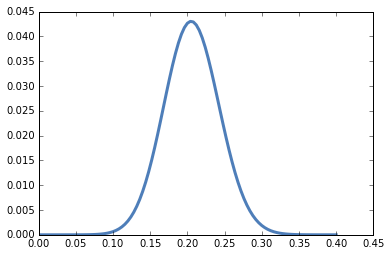

In [20]:
pmf_slope = blogit.Marginal(0)
thinkplot.Pdf(pmf_slope)
pmf_slope.CredibleInterval(95)

And for the intercept parameter:

(-2.2199999999999998, -1.4399999999999999)

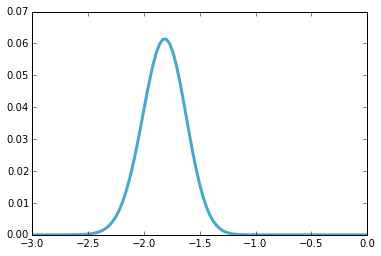

In [21]:
pmf_inter = blogit.Marginal(1)
thinkplot.Pdf(pmf_inter)
pmf_inter.CredibleInterval(95)

And here's the joint distribution

/home/downey/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


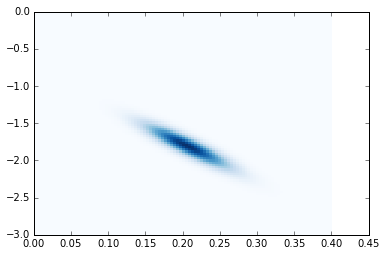

In [22]:
thinkplot.Contour(blogit, pcolor=True, contour=False)

From the posterior distribution of the parameters, we can generate a predictive distribution of probability for each score:

In [23]:
def make_predictive(blogit, score):
    pmf = thinkbayes2.Pmf()
    for (slope, inter), prob in blogit.Items():
        x = score * slope + inter
        o = np.exp(x)
        p = o / (1+o)
        pmf[p] = prob
    return pmf

Here's what the posterior predictive distributions look like for a range of scores.

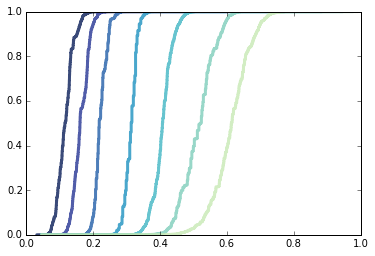

In [24]:
scores = [-1, 1, 3, 5, 7, 9, 11]
thinkplot.PrePlot(len(scores))
for score in scores:
    pmf = make_predictive(blogit, score)
    thinkplot.Cdf(pmf.MakeCdf())

We can also plot the results with a line plot and 95% credible intervals.

In [25]:
cdfs = [make_predictive(blogit, score).MakeCdf() for score in scores]

Extracting the medians and credible intervals from the posterior predictive distributions.

In [26]:
medians = np.array([cdf.Percentile(50) for cdf in cdfs])
cis = np.array([cdf.CredibleInterval(95) for cdf in cdfs])

And here's what they look like.

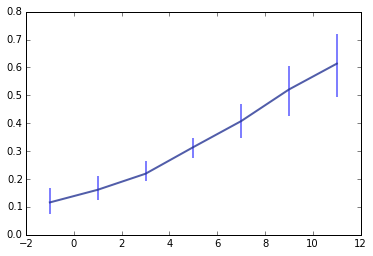

In [27]:
def plot_bayesian_regression(scores, medians, cis):
    for score, (low, high) in zip(scores, cis):
        plt.vlines(score, low, high, color='blue', alpha=0.5, linewidth=2)
    thinkplot.PrePlot(1)
    thinkplot.plot(scores, medians, linewidth=2)

scores = [-1, 1, 3, 5, 7, 9, 11]
plot_bayesian_regression(scores, medians, cis)


If we superimpose the lines from the logistic regression, we can compare them:

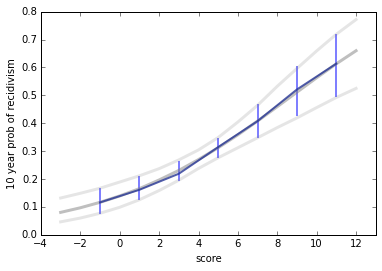

In [54]:
plot_regressions(df)

scores = [-1, 1, 3, 5, 7, 9, 11]
plot_bayesian_regression(scores, medians, cis)
thinkplot.Config(xlabel='score', ylabel='10 year prob of recidivism', xlim=[-4, 13])

The Bayesian and logistic regressions agree about the median values.  And the credible intervals for the Bayesian regression are the same as the confidence intervals for the logistic regression.

So if you don't have an informative prior, and all you want is the median of the posterior distribution and a measure of precision, the Bayesian method has no real advantage.

###Categorical

Next we can explore another way to estimate risk for each group.  This one turns out to be bad, so feel free to skip it.

If we treat score as a categorical variable, we can estimate risk for each score separately.

In [29]:
grouped = df.groupby('score')
for name, group in grouped:
    print(name, len(group))

-2.0 2
-1.0 24
0.0 31
1.0 56
2.0 42
3.0 82
4.0 130
5.0 133
6.0 83
7.0 61
8.0 32
9.0 17
10.0 9
11.0 1


I'll use a Beta distribution for each group.

In [30]:
def MakeBeta(group):
    yes = sum(group.recid == 1)
    no = sum(group.recid==0)
    beta = thinkbayes2.Beta(yes+1, no+1)
    return beta

betas = {}
for name, group in grouped:
    betas[name] = MakeBeta(group)

And then extract the median and 95% credible interval from each posterior.

In [31]:
rows=[]
for name, beta in sorted(betas.items()):
    cdf = beta.MakeCdf()
    low = cdf.Percentile(2.5)
    mean = beta.Mean()
    high = cdf.Percentile(97.5)
    rows.append((low, mean, high))
    
array = np.array(rows).transpose()
scores = sorted(betas)
lows = array[0,]
means = array[1,]
highs = array[2,]

The result is kind of a mess, with credible intervals much wider than the CIs from logistic regression.

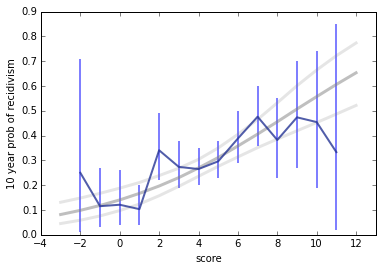

In [32]:
plot_regressions(df)

for score, low, high in zip(scores, lows, highs):
        plt.vlines(score, low, high, color='blue', alpha=0.5, linewidth=2)
        
thinkplot.PrePlot(1)
thinkplot.plot(scores, means, linewidth=2)
thinkplot.Config(xlabel='score', ylabel='10 year prob of recidivism', xlim=[-4, 13])

### Logistic regression with a quadratic model

One last option to consider is a quadratic model of risk.

Here the linear model again:

In [33]:
formula = 'recid ~ score'
model = smf.logit(formula, data=df)
results = model.fit(disp=False)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  recid   No. Observations:                  703
Model:                          Logit   Df Residuals:                      701
Method:                           MLE   Df Model:                            1
Date:                Fri, 13 Nov 2015   Pseudo R-squ.:                 0.03919
Time:                        09:56:55   Log-Likelihood:                -406.84
converged:                       True   LL-Null:                       -423.43
                                        LLR p-value:                 8.371e-09
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.8129      0.194     -9.335      0.000        -2.194    -1.432
score          0.2048      0.037      5.534      0.000         0.132     0.277
==============================================================================
"""

And here's the quadratic version.

In [34]:
df['score2'] = df.score**2

formula = 'recid ~ score + score2'
model = smf.logit(formula, data=df)
results = model.fit(disp=False)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  recid   No. Observations:                  703
Model:                          Logit   Df Residuals:                      700
Method:                           MLE   Df Model:                            2
Date:                Fri, 13 Nov 2015   Pseudo R-squ.:                 0.04235
Time:                        09:56:55   Log-Likelihood:                -405.49
converged:                       True   LL-Null:                       -423.43
                                        LLR p-value:                 1.626e-08
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -2.1210      0.288     -7.354      0.000        -2.686    -1.556
score          0.3820      0.119      3.209      0.001         0.149     0.615
score2        -0.0193      0.012     -1.601      0.109        -0.043     0.004
==============================================================================
"""

The square term is not significant.

Also if we plot the predictions of the two models:

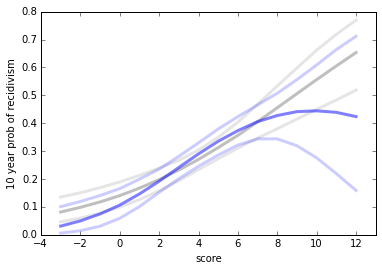

In [53]:
plot_regressions(df, formula='recid ~ score')
plot_regressions(df, formula='recid ~ score + score2', color='blue')
thinkplot.Config(xlabel='score', ylabel='10 year prob of recidivism', xlim=[-4, 13])

The quadratic model is getting pulled down by the low recidivism rates in the highest groups, which are based on small sample sizes.  So this model is likely overfit to the data.

###PTPP

Another approach is to pose a different question: if we choose a threshold on the score, and consider a score at or above the threshold to be a "positive test", and recidivism to be a "condition of interest", what can we say about the specificity, sensitivity, and post-test probabilities?

I'll run an example with a threshold of 6.

In [36]:
testpos = df.score >= 6

Here's the cross tabulation of test outcome and recidivism:

In [37]:
tab = pd.crosstab(testpos, df.recid)
tab

recid,0,1
score,,
False,381,119
True,118,85


Sensitivity (fraction of recidivists the test detects)

In [38]:
sens = tab[1][True] / sum(tab[1])
sens

0.41666666666666669

Specificity (fraction of non-recidivists who test negative)

In [39]:
spec = tab[0][False] / sum(tab[0])
spec

0.76352705410821642

Post-test probability of recidivism given positive test (PTPP)

In [40]:
ptpp = tab[1][True] / sum(testpos)
ptpp

0.41871921182266009

Post-test probability of non-recidivism given negative test (PTPN)

In [41]:
ptpn = tab[0][False] / sum(testpos == False)
ptpn

0.76200000000000001

Each of these quantities is a proportion estimated based on a ratio of frequencies, so if the prior distribution is Beta, the posterior distribution is also Beta.

Following Crawford et al, I'll uses a prior distribution with $\alpha = \beta = 0$ (although I don't buy their justification for this choice).

In [42]:
def MakeBeta(yes, no, alpha=0, beta=0):
    return thinkbayes2.Beta(yes+alpha, no+beta)

Now we can make a posterior distribution for sensitivity, and confirm that the posterior mean is the same as the observed proportion.

In [43]:
sens_dist = MakeBeta(tab[1][True], tab[1][False])
sens_dist.Mean()

0.41666666666666669

And likewise for specificity:

In [44]:
spec_dist = MakeBeta(tab[0][False], tab[0][True])
spec_dist.Mean()

0.76352705410821642

And PTPP

In [45]:
ptpp_dist = MakeBeta(tab[1][True], tab[0][True])
ptpp_dist.Mean()

0.41871921182266009

Here's what the posterior distribution looks like for PTPP

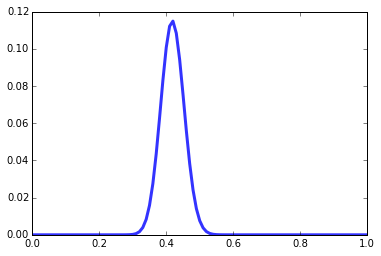

In [46]:
thinkplot.Pdf(ptpp_dist.MakePmf())

And here's the symmetric 95% credible interval.  There is a 95% chance that the actual value falls in this interval (subject to the validity of the data as a representative sample).

In [47]:
symm_ci = ptpp_dist.Percentile([2.5, 97.5])
symm_ci

array([ 0.35185214,  0.48710358])

Here's the 95th percentile, which could be consider a sort of upper bound.

In [48]:
low_ci = ptpp_dist.Percentile([0, 95])
low_ci

array([ 0.        ,  0.47600745])

And the 5th percentile, a sort of lower bound.

In [49]:
high_ci = ptpp_dist.Percentile([5, 100])
high_ci

array([ 0.36234389,  1.        ])

I'll wrap this process up in a function:

In [50]:
def estimate_ptpp(df, thresh):
    testpos = df.score >= thresh
    tab = pd.crosstab(testpos, df.recid)
    ptpp_dist = MakeBeta(tab[1][True], tab[0][True])
    est = ptpp_dist.Mean()
    ci = ptpp_dist.Percentile([2.5, 97.5])
    return est, ci.tolist()

estimate_ptpp(df, 6)

(0.41871921182266009, [0.3518521419235516, 0.48710358239969676])

And now we can try it out with difference choices for the threshold:

In [51]:
for thresh in range(-2, 11):
    print(thresh, estimate_ptpp(df, thresh))

-2 (0.29018492176386912, [0.257238685423252, 0.32426188788597143])
-1 (0.29101283880171186, [0.25799004591947694, 0.32516511391927216])
0 (0.2983751846381093, [0.2645132327072705, 0.33336546689622504])
1 (0.30804953560371517, [0.27305246225166213, 0.3441723583875195])
2 (0.32881355932203388, [0.29150490164753645, 0.36722150461892855])
3 (0.32846715328467152, [0.289792273616399, 0.36832796975593507])
4 (0.33905579399141633, [0.2967986471722945, 0.3826214938883786])
5 (0.36904761904761907, [0.31830277635205195, 0.4212691852755268])
6 (0.41871921182266009, [0.3518521419235516, 0.48710358239969676])
7 (0.44166666666666665, [0.3542685323315231, 0.5309072169144622])
8 (0.40677966101694918, [0.2859632642550582, 0.5335854545353503])
9 (0.44444444444444442, [0.26587121742295106, 0.6308196190760335])
10 (0.40000000000000002, [0.1369956622651665, 0.7007049437914596])


If the goal is to chose the threshold that maximizes PTPP, 7 is the best choice.

In that case we could say that of all people who score 7 or more, 44% of them will be charged with a new crime within 10 years (that's the definition of recidivism the data are based on).

But within that group, people with different scores have different probabilities of recidivism.  From the logistic regression model

    score     prob
    7         0.406206803608
    8         0.456381885955
    9         0.507458085398
    10        0.558379071389
    11        0.608101233976
    
So lumping everone above 6 into a single category might be generous to the 11s and harsh to the 7s.

If the goal of the analysis is to estimate the probability of recidivism for an individual, the logistic regression model is an appropriate choice.

If the goal is to choose a threshold and compute some of the consequences of applying that threshold, the PTPP analysis is appropriate.



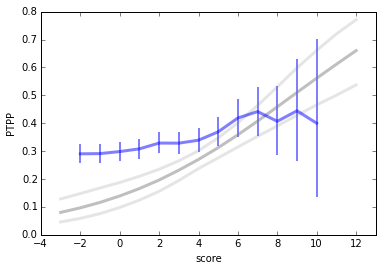

In [52]:
plot_regressions(df)

threshes = range(-2, 11)
meds = []
for thresh in threshes:
    med, (low, high) = estimate_ptpp(df, thresh)
    plt.vlines(thresh, low, high, color='blue', alpha=0.5, linewidth=2)

    meds.append(med)
    
thinkplot.Plot(threshes, meds, color='blue', alpha=0.5)
thinkplot.Config(xlabel='score', ylabel='PTPP', xlim=[-4, 13])